# Predicting cell types from Single Cell RNA-Seq

In [6]:
!pip install scanpy anndata seaborn scikit-learn igraph leidenalg

## Package imports

In [7]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim

seed=2
np.random.seed(seed)
torch.manual_seed(seed)

## Load the dataset

In [8]:
adata = sc.datasets.pbmc3k()
print(adata)

# Store the original full dataset in adata_full before HVG subsetting
adata_full = adata.raw.to_adata() if adata.raw is not None else adata.copy()

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


## Data Preprocessing

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# Unsupervised learning


## Leiden clustering

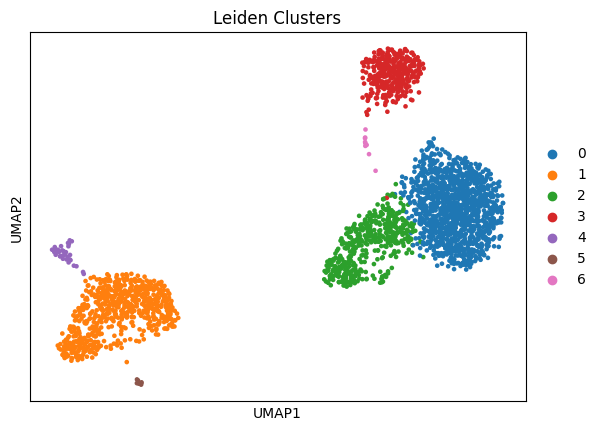

In [10]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'], title='Leiden Clusters')

## Annotate cell types

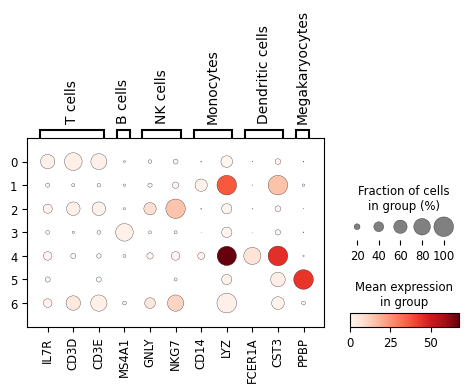

In [11]:
marker_genes = {
    "T cells": ["IL7R", "CD3D", "CD3E"],
    "B cells": ["MS4A1"],
    "NK cells": ["GNLY", "NKG7"],
    "Monocytes": ["CD14", "LYZ"],
    "Dendritic cells": ["FCER1A", "CST3"],
    "Megakaryocytes": ["PPBP"],
}

# Use full data for dotplot
# Ensure adata_full has the same cell indices as adata
adata_full.obs['leiden'] = adata.obs['leiden'].copy()
sc.pl.dotplot(adata_full, marker_genes, groupby='leiden')

In [12]:
# sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


Cell type distribution:
cell_type
T cells                      1203
Monocytes                     653
NK cells                      439
B cells                       348
Monocytes/Dendritic cells      36
Megakaryocytes                 12
Unknown                         9
Name: count, dtype: int64


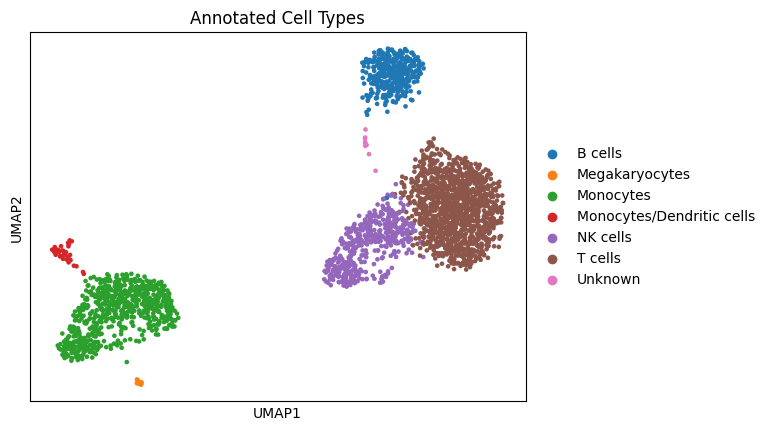

In [13]:
cluster2celltype = {
    '0': 'T cells',
    '1': 'Monocytes',
    '2': 'NK cells',
    '3': 'B cells',
    '4': 'Monocytes/Dendritic cells',
    '5': 'Megakaryocytes'
}
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster2celltype)
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category').cat.add_categories(["Unknown"]).fillna("Unknown")

print("Cell type distribution:")
print(adata.obs['cell_type'].value_counts())

sc.pl.umap(adata, color='cell_type', title='Annotated Cell Types')

## K-means clustering

=== K-means vs. Leiden Comparison ===
Adjusted Rand Index (ARI): 0.834
Normalized Mutual Information (NMI): 0.834
Homogeneity: 0.913


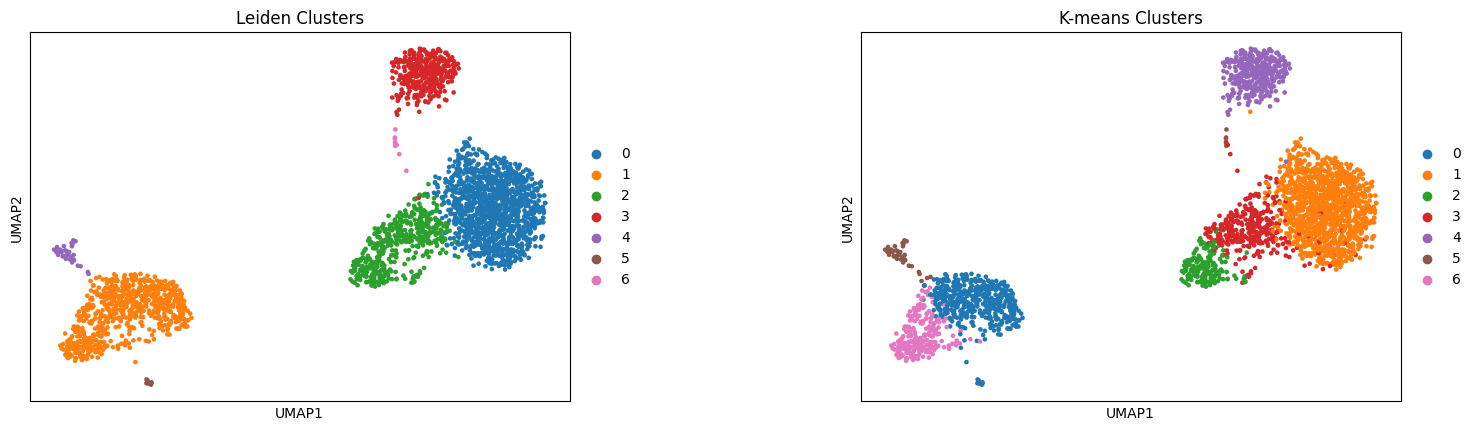

In [14]:
# Run K-means on PCA space
X_pca = adata.obsm['X_pca']
n_clusters = adata.obs['leiden'].nunique()  # match Leiden cluster count for fairness
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
adata.obs['kmeans'] = kmeans.fit_predict(X_pca).astype(str)

# Compare clustering results
ari = adjusted_rand_score(adata.obs['leiden'], adata.obs['kmeans'])
nmi = normalized_mutual_info_score(adata.obs['leiden'], adata.obs['kmeans'])
hom = homogeneity_score(adata.obs['leiden'], adata.obs['kmeans'])

print("=== K-means vs. Leiden Comparison ===")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")
print(f"Homogeneity: {hom:.3f}")

# Visualization
sc.pl.umap(
    adata,
    color=['leiden', 'kmeans'],
    wspace=0.4,
    title=['Leiden Clusters', 'K-means Clusters']
)

## Hierarchical clustering

=== Hierarchical vs. Leiden Comparison ===
Adjusted Rand Index (ARI): 0.835
Normalized Mutual Information (NMI): 0.820
Homogeneity: 0.886


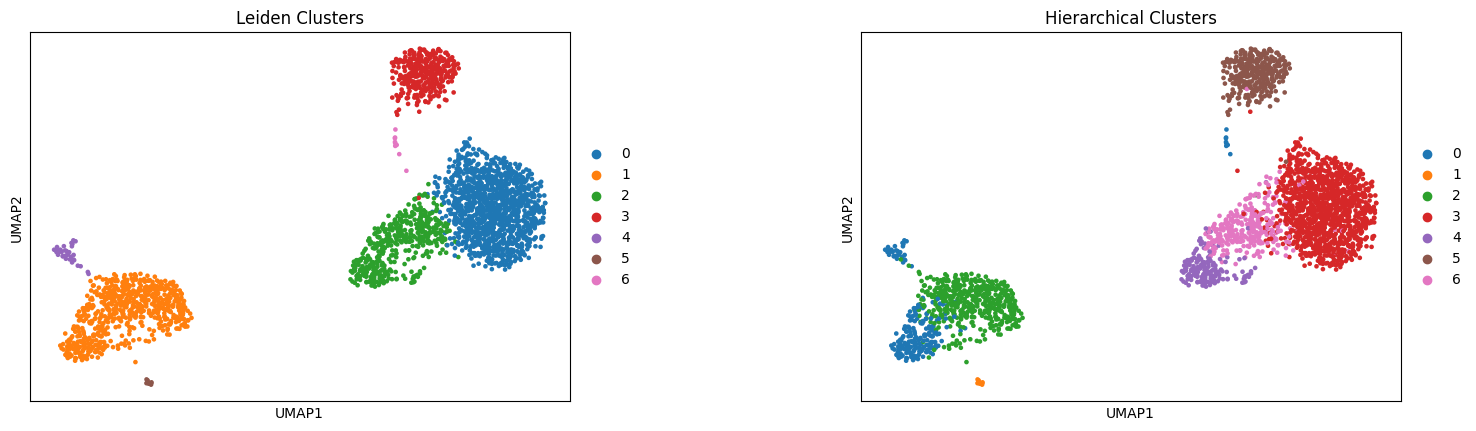

In [15]:
n_clusters = adata.obs['leiden'].nunique()  # same cluster count as Leiden
agg = AgglomerativeClustering(n_clusters=n_clusters)
adata.obs['hierarchical'] = agg.fit_predict(X_pca).astype(str)

# Compare clustering results
ari_h = adjusted_rand_score(adata.obs['leiden'], adata.obs['hierarchical'])
nmi_h = normalized_mutual_info_score(adata.obs['leiden'], adata.obs['hierarchical'])
hom_h = homogeneity_score(adata.obs['leiden'], adata.obs['hierarchical'])

print("=== Hierarchical vs. Leiden Comparison ===")
print(f"Adjusted Rand Index (ARI): {ari_h:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi_h:.3f}")
print(f"Homogeneity: {hom_h:.3f}")

# Visualization
sc.pl.umap(
    adata,
    color=['leiden', 'hierarchical'],
    wspace=0.4,
    title=['Leiden Clusters', 'Hierarchical Clusters']
)

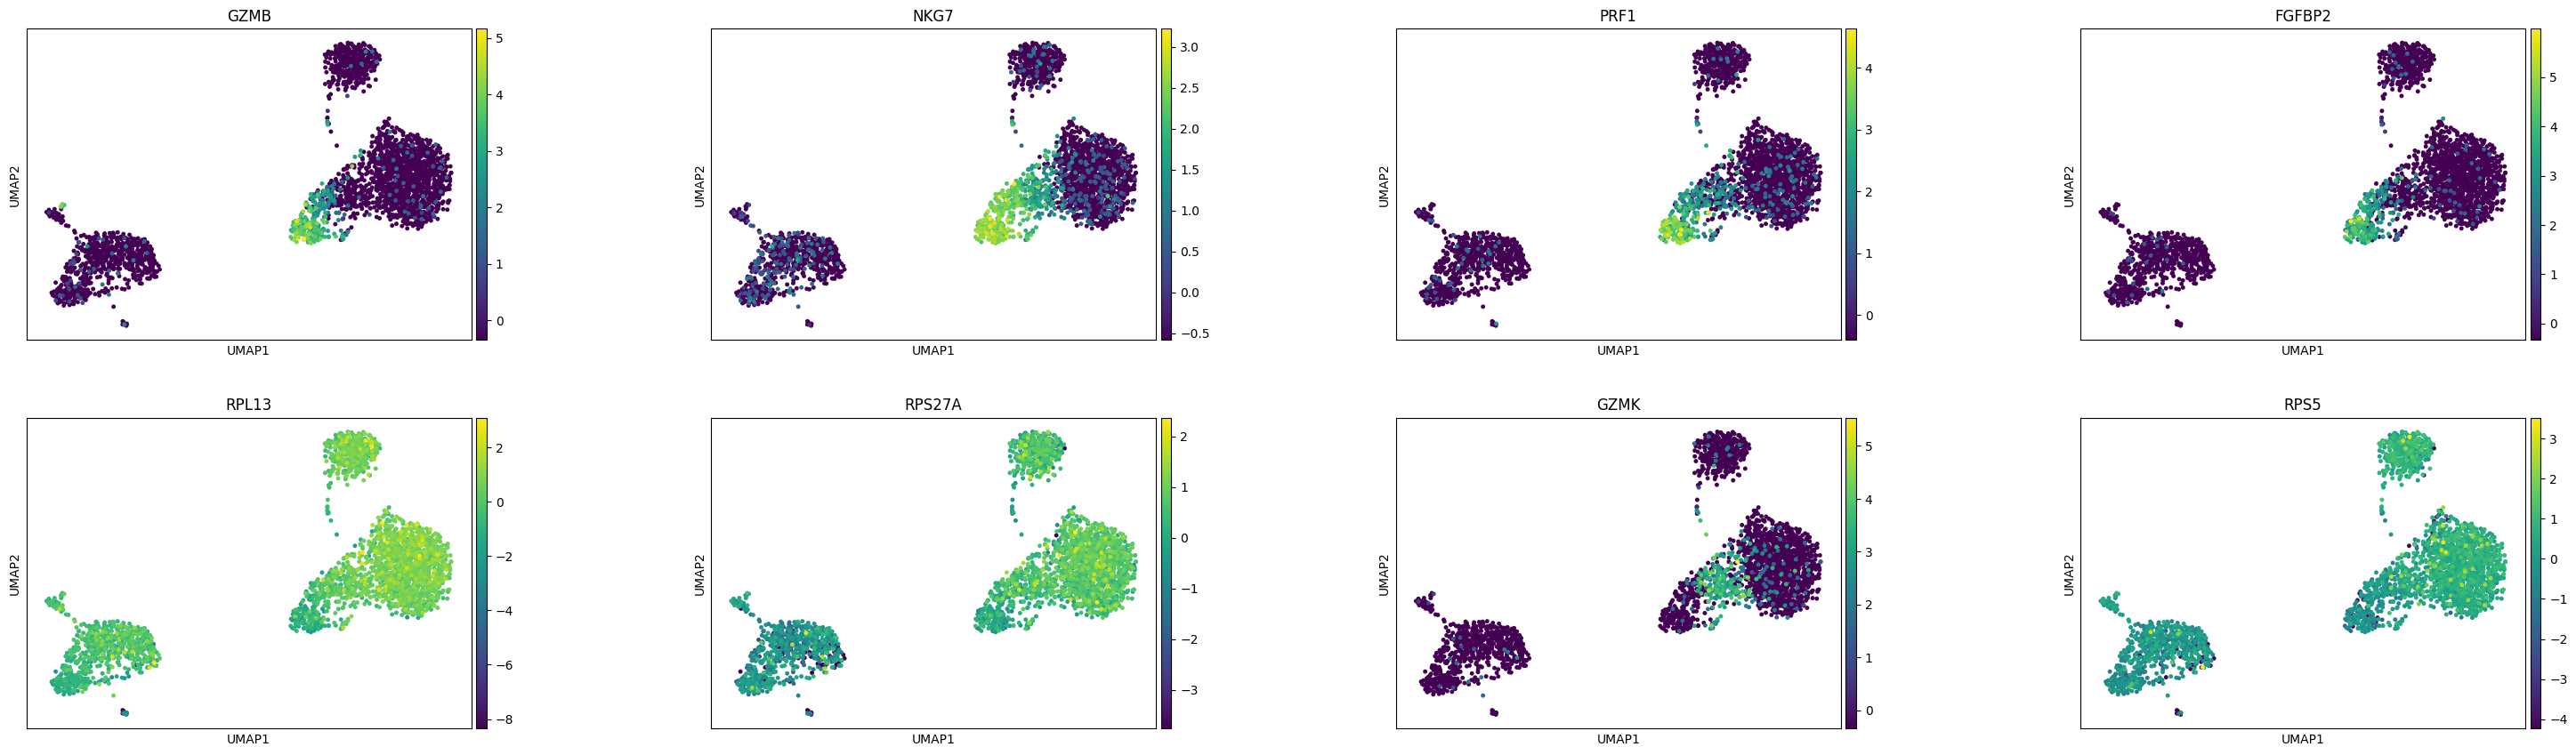

In [16]:
clusters_of_interest = ['2','3']  # K-means subcluster labels within Leiden 2
adata_sub = adata[adata.obs['kmeans'].isin(clusters_of_interest)].copy()
adata_sub.obs['kmeans'] = adata_sub.obs['kmeans'].cat.remove_unused_categories()

# Differential expression
sc.tl.rank_genes_groups(adata_sub, groupby='kmeans', method='wilcoxon')

# Extract top 4 genes for each subcluster
top_genes_cluster0 = sc.get.rank_genes_groups_df(adata_sub, group=adata_sub.obs['kmeans'].cat.categories[0])['names'].head(4).tolist()
top_genes_cluster1 = sc.get.rank_genes_groups_df(adata_sub, group=adata_sub.obs['kmeans'].cat.categories[1])['names'].head(4).tolist()

# Combine for plotting
genes_to_plot = top_genes_cluster0 + top_genes_cluster1

# UMAP plot showing expression of top DE genes
sc.pl.umap(adata, color=genes_to_plot, cmap='viridis', size=50, wspace=0.4)

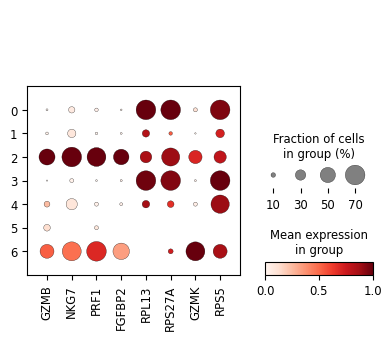

In [17]:
sc.pl.dotplot(adata, var_names=genes_to_plot, groupby='leiden', standard_scale='var', dot_max=0.7)

# Supervised learning

## Prepare data for supervised machine learning

In [18]:
X = adata.X
y = adata.obs['cell_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

In [19]:
# sc.pp.highly_variable_genes(adata, n_top_genes=2000)
# adata = adata[:, adata.var['highly_variable']]
# print(adata.shape)

## Logistic Regression

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 1, 'l1_ratio': 0.5}
Best CV score: 0.975
=== Logistic Regression (Elastic Net) ===
                           precision    recall  f1-score   support

                  B cells       1.00      1.00      1.00        70
           Megakaryocytes       0.67      1.00      0.80         2
                Monocytes       1.00      0.99      1.00       131
Monocytes/Dendritic cells       0.88      1.00      0.93         7
                 NK cells       0.95      0.94      0.95        88
                  T cells       0.98      0.98      0.98       240
                  Unknown       1.00      1.00      1.00         2

                 accuracy                           0.98       540
                macro avg       0.92      0.99      0.95       540
             weighted avg       0.98      0.98      0.98       540

Balanced accuracy: 0.9878164138660323
Weighted F1: 0.9798253765533458


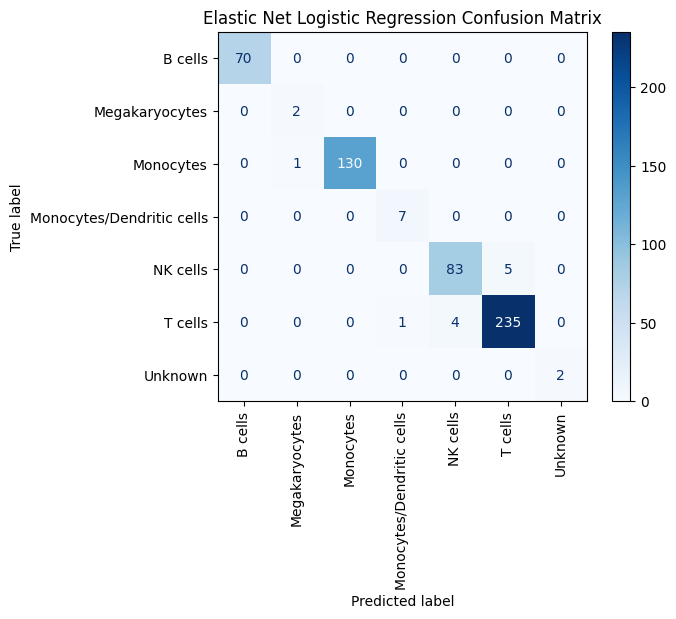

In [20]:
param_grid = {
    'C': [1],
    'l1_ratio': [0.5],
}

logreg = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=500,
    class_weight='balanced',
    random_state=seed
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

grid = GridSearchCV(logreg, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Evaluate on test set
best_logreg = grid.best_estimator_
y_pred = best_logreg.predict(X_test)

print("=== Logistic Regression (Elastic Net) ===")
print(classification_report(y_test, y_pred))

balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print("Balanced accuracy:", balanced_acc)
print("Weighted F1:", f1_weighted)

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Elastic Net Logistic Regression Confusion Matrix")
plt.show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters: {'C': 10, 'gamma': 'scale'}
Best CV score: 0.9550925925925926
=== SVM Classification Report ===
                           precision    recall  f1-score   support

                  B cells       0.99      0.99      0.99        70
           Megakaryocytes       0.00      0.00      0.00         2
                Monocytes       0.96      1.00      0.98       131
Monocytes/Dendritic cells       1.00      0.29      0.44         7
                 NK cells       0.96      0.88      0.92        88
                  T cells       0.95      1.00      0.97       240
                  Unknown       0.00      0.00      0.00         2

                 accuracy                           0.96       540
                macro avg       0.69      0.59      0.61       540
             weighted avg       0.95      0.96      0.95       540

Balanced accuracy: 0.5917517006802722
Weighted F1-score: 0.952760302107676
SVM mod

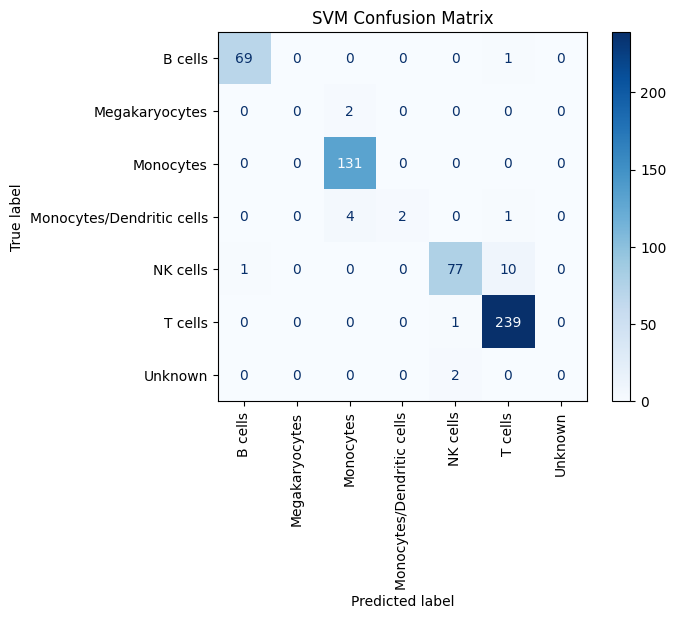

In [21]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define SVM and parameter grid
svm = SVC(
      kernel='rbf',
      class_weight='balanced',
      decision_function_shape='ovo',
      probability=True,
      random_state=seed)

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Grid search
grid_svm = GridSearchCV(svm, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_svm.fit(X_train_scaled, y_train)

# 4. Best estimator
svm_best = grid_svm.best_estimator_
print("Best hyperparameters:", grid_svm.best_params_)
print("Best CV score:", grid_svm.best_score_)

# Predict on test set
y_pred_svm = svm_best.predict(X_test_scaled)

# Evaluation
print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_svm))
print("Weighted F1-score:", f1_score(y_test, y_pred_svm, average='weighted'))

joblib.dump(svm_best, "svm_model_best.pkl")
joblib.dump(scaler, "scaler.pkl")
print("SVM model and scaler saved successfully!")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.xticks(rotation=90)
plt.title("SVM Confusion Matrix")
plt.show()

In [22]:
svm_loaded = joblib.load("svm_model_best.pkl")
scaler_loaded = joblib.load("scaler.pkl")


X_new_scaled = scaler_loaded.transform(X_test)
y_pred_new = svm_loaded.predict(X_new_scaled)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best CV score: 0.9740740740740741
=== XGBoost Classification Report ===
                           precision    recall  f1-score   support

                  B cells       0.97      0.99      0.98        70
           Megakaryocytes       1.00      1.00      1.00         2
                Monocytes       1.00      0.99      1.00       131
Monocytes/Dendritic cells       1.00      1.00      1.00         7
                 NK cells       0.92      0.93      0.93        88
                  T cells       0.97      0.97      0.97       240
                  Unknown       1.00      1.00      1.00         2

                 accuracy                           0.97       540
                macro avg       0.98      0.98      0.98       540
             weighted avg       0.97      0.97      0.97       540

Balanced accuracy: 0.9829617447256488
Weighte

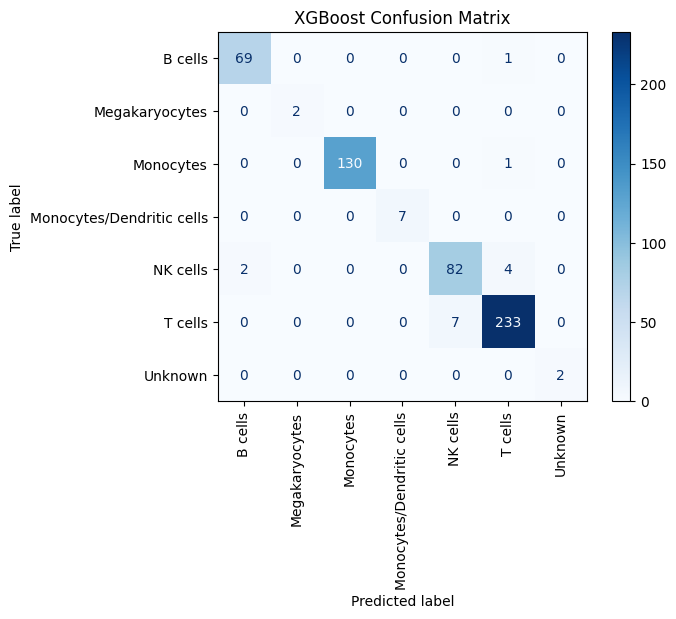

XGBoost model and scaler saved successfully!


In [23]:
# Scale features
scaler_xgb = StandardScaler()
X_train_scaled = scaler_xgb.fit_transform(X_train)
X_test_scaled = scaler_xgb.transform(X_test)

# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define XGBoost classifier and parameter grid
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=seed
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Grid search
grid_xgb = GridSearchCV(xgb, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train_scaled, y_train_encoded)

# Best estimator
xgb_best = grid_xgb.best_estimator_
print("Best hyperparameters:", grid_xgb.best_params_)
print("Best CV score:", grid_xgb.best_score_)

# Predict on test set
y_pred_encoded = xgb_best.predict(X_test_scaled)
y_pred_xgb = le.inverse_transform(y_pred_encoded)

# Evaluation
print("=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred_xgb))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_xgb))
print("Weighted F1-score:", f1_score(y_test, y_pred_xgb, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.xticks(rotation=90)
plt.title("XGBoost Confusion Matrix")
plt.show()

# Save model and scaler
joblib.dump(xgb_best, "xgb_model_best.pkl")
joblib.dump(scaler_xgb, "scaler_xgb.pkl")
print("XGBoost model and scaler saved successfully!")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'max_depth': 5, 'n_estimators': 200}
Best CV score: 0.9708333333333334
=== Random Forest Classification Report ===
                           precision    recall  f1-score   support

                  B cells       0.97      0.99      0.98        70
           Megakaryocytes       1.00      1.00      1.00         2
                Monocytes       0.99      0.99      0.99       131
Monocytes/Dendritic cells       1.00      0.86      0.92         7
                 NK cells       0.93      0.91      0.92        88
                  T cells       0.97      0.98      0.97       240
                  Unknown       1.00      0.50      0.67         2

                 accuracy                           0.97       540
                macro avg       0.98      0.89      0.92       540
             weighted avg       0.97      0.97      0.97       540

Balanced accuracy: 0.8890687329754943
Weighted F1-score: 0.96

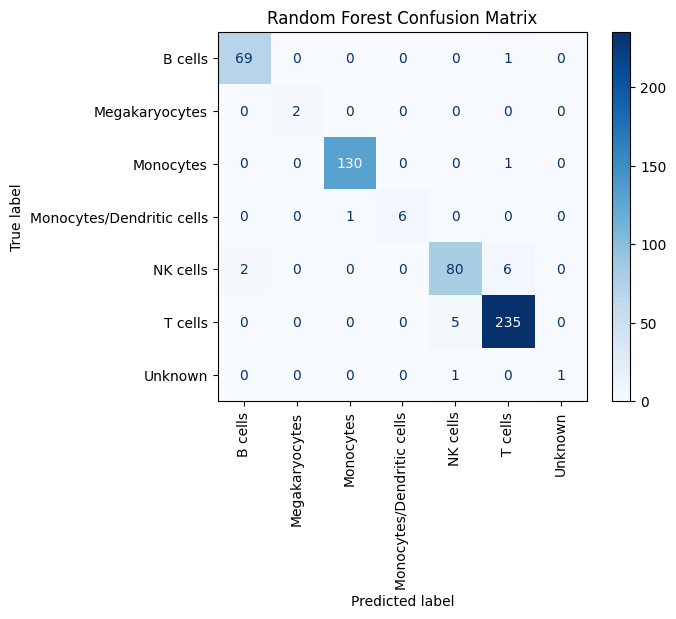

In [24]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 20, 200],
}

# Create Random Forest classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=seed)

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Grid search for best hyperparameters
grid_rf = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_
print("Best hyperparameters:", grid_rf.best_params_)
print("Best CV score:", grid_rf.best_score_)

# Predictions on test set
y_pred_rf = best_rf.predict(X_test)

# Classification report and weighted metrics
print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print("Weighted F1-score:", f1_score(y_test, y_pred_rf, average='weighted'))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y_test))
ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Random Forest Confusion Matrix")
plt.show()

In [25]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed
)

# Encode labels
cell_types = np.unique(y_train)
label2idx = {label: i for i, label in enumerate(cell_types)}
y_train_idx = np.array([label2idx[lab] for lab in y_train_sub])
y_val_idx = np.array([label2idx[lab] for lab in y_val])
y_test_idx = np.array([label2idx[lab] for lab in y_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_sub, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

In [26]:
class EarlyStopping:
    """Monitors validation loss and stores the best model state dict."""
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.best_state_dict = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_state_dict = model.state_dict()
            self.counter = 0
            return False  # do not stop
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # stop training
            return False

In [27]:
# Define MLPClassifier class
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden1=256, hidden2=128, output_dim=6, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, output_dim)
        )

    def forward(self, x):
        return self.net(x)

    def predict(self, x):
        """
        Returns predicted class labels for input x.
        - x: torch.Tensor or numpy.ndarray of shape (n_samples, n_features)
        """
        # Ensure input is a torch tensor
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)

        self.eval()  # evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            preds = torch.argmax(logits, dim=1)
        return preds.cpu().numpy()

In [28]:
input_dim = X_train_tensor.shape[1]
output_dim = len(cell_types)
model = MLPClassifier(input_dim=input_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=5)
epochs = 50
batch_size = 64

for epoch in range(epochs):
    # Training
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))
    train_loss = 0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= (X_train_tensor.size(0) // batch_size + 1)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if early_stopper.step(val_loss, model):
        print("Early stopping triggered.")
        break

# Load best model
model.load_state_dict(early_stopper.best_state_dict)

Epoch 1, Train Loss: 0.7462, Val Loss: 0.1881
Epoch 2, Train Loss: 0.0781, Val Loss: 0.1290
Epoch 3, Train Loss: 0.0272, Val Loss: 0.1136
Epoch 4, Train Loss: 0.0129, Val Loss: 0.1207
Epoch 5, Train Loss: 0.0049, Val Loss: 0.1285
Epoch 6, Train Loss: 0.0031, Val Loss: 0.1312
Epoch 7, Train Loss: 0.0015, Val Loss: 0.1332
Epoch 8, Train Loss: 0.0007, Val Loss: 0.1378
Early stopping triggered.


<All keys matched successfully>

=== PyTorch MLP Classification Report ===
                           precision    recall  f1-score   support

                  B cells       1.00      1.00      1.00        70
           Megakaryocytes       0.67      1.00      0.80         2
                Monocytes       0.99      0.99      0.99       131
Monocytes/Dendritic cells       1.00      0.86      0.92         7
                 NK cells       0.96      0.92      0.94        88
                  T cells       0.97      0.99      0.98       240
                  Unknown       1.00      1.00      1.00         2

                 accuracy                           0.98       540
                macro avg       0.94      0.97      0.95       540
             weighted avg       0.98      0.98      0.98       540

Balanced accuracy: 0.965351973544449
Weighted F1-score: 0.9777529290848528


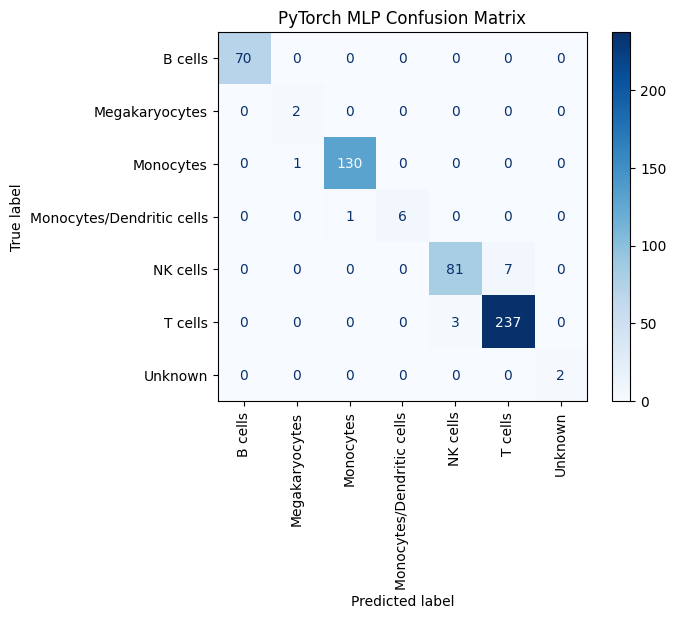

In [29]:
y_pred_idx = model.predict(X_test_tensor)
y_pred = [cell_types[i] for i in y_pred_idx]

print("=== PyTorch MLP Classification Report ===")
print(classification_report(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Weighted F1-score:", f1_score(y_test, y_pred, average='weighted'))

cm = confusion_matrix(y_test, y_pred, labels=cell_types)
ConfusionMatrixDisplay(cm, display_labels=cell_types).plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("PyTorch MLP Confusion Matrix")
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Collect predictions from your models
y_pred_logreg = best_logreg.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_mlp = [cell_types[i] for i in model.predict(X_test_tensor)]


# Compute metrics
results = {
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_logreg),
        "Balanced accuracy": balanced_accuracy_score(y_test, y_pred_logreg),
        "F1 (weighted)": f1_score(y_test, y_pred_logreg, average="weighted"),
        "Precision (weighted)": precision_score(y_test, y_pred_logreg, average="weighted"),
        "Recall (weighted)": recall_score(y_test, y_pred_logreg, average="weighted"),
    },
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Balanced accuracy": balanced_accuracy_score(y_test, y_pred_rf),
        "F1 (weighted)": f1_score(y_test, y_pred_rf, average="weighted"),
        "Precision (weighted)": precision_score(y_test, y_pred_rf, average="weighted"),
        "Recall (weighted)": recall_score(y_test, y_pred_rf, average="weighted"),
    },
    "MLP": {
        "Accuracy": accuracy_score(y_test, y_pred_mlp),
        "Balanced accuracy": balanced_accuracy_score(y_test, y_pred_mlp),
        "F1 (weighted)": f1_score(y_test, y_pred_mlp, average="weighted"),
        "Precision (weighted)": precision_score(y_test, y_pred_mlp, average="weighted"),
        "Recall (weighted)": recall_score(y_test, y_pred_mlp, average="weighted"),
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_xgb),
        "Balanced accuracy": balanced_accuracy_score(y_test, y_pred_xgb),
        "F1 (weighted)": f1_score(y_test, y_pred_xgb, average="weighted"),
        "Precision (weighted)": precision_score(y_test, y_pred_xgb, average="weighted"),
        "Recall (weighted)": recall_score(y_test, y_pred_xgb, average="weighted"),
    },
    "SVM": {
        "Accuracy": accuracy_score(y_test, y_pred_svm),
        "Balanced accuracy": balanced_accuracy_score(y_test, y_pred_svm),
        "F1 (weighted)": f1_score(y_test, y_pred_svm, average="weighted"),
        "Precision (weighted)": precision_score(y_test, y_pred_svm, average="weighted"),
        "Recall (weighted)": recall_score(y_test, y_pred_svm, average="weighted"),
    }
}

# Create DataFrame for nice display
results_df = pd.DataFrame(results).T
display(results_df.round(3))

,Accuracy,Balanced accuracy,F1 (weighted),Precision (weighted),Recall (weighted)
Logistic Regression,0.980,0.988,0.980,0.980,0.980
Random Forest,0.969,0.889,0.968,0.968,0.969
MLP,0.978,0.965,0.978,0.978,0.978
XGBoost,0.972,0.983,0.972,0.972,0.972
SVM,0.959,0.592,0.953,0.953,0.959


Performance evaluation of our different supervised models (LogReg, Random Forest, MLP, XGBoost, SVM)

In [31]:
models = {
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
    "LogReg": logreg_model
}

plot_roc(models, X_test, y_test)

NameError: name 'rf_model' is not defined

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(models, X_test, y_test):
    """
    models : dict { 'nom_model': modele_fite }
    """

    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        # Probabilités prédites pour la classe positive
        y_score = model.predict_proba(X_test)[:, 1]

        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # Tracé
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

    # Ligne du hasard
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Courbes ROC pour différents modèles")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()